In [8]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys
import geopandas as gpd
from matplotlib import pyplot as plt

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'

img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X'
array_pickles = funcoes.ler_diretorios(pickle_dir, img_especifica)
vetor_informacoes = []

tracados = f'{root_dir}/Artificial_Lines/array_arquivos.json'
array_medial_path = backgen.retorna_paths(tracados)

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))

for i in range(len(array_medial_path)):  
  n_random = np.random.randint(0, len(array_pickles), size=1) 
  print(n_random)
  path = (pickle_dir + f'/{array_pickles[n_random[0]]}') 
  print(path)
  arquivo_pickle = pickle.load(open(path, 'rb'))
  #print(array_pickles)
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values,
  imagem_binaria_original = vessel_map.mapped_mask_values
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)
  rows, cols = mapa_original[0].shape
  limiar = backgen.encontrar_pixel_mais_frequente(mapa_original[0])
  distancia = (rows/2)
  caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_medial_path[i], 2) # type: ignore
  maior_valor_interpolado = np.max(caminhos_transladados_interpolado[0])
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original[0],maior_valor_interpolado)
  mapa_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor_interpolado)  
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original": imagem_binaria_original,
      "imagem_binaria_sem_artefatos_laterais": imagem_binaria_sem_artefatos_laterais,  
      "imagem_binaria_sem_artefatos": imagem_binaria_sem_artefatos,
      "caminhos_transladados_interpolado": caminhos_transladados_interpolado,
      "maior_valor_interpolado": maior_valor_interpolado,
      "mapa_expandido_original": mapa_expandido_original,
      "mapa_expandido_bin": mapa_expandido_bin,
      "rows": rows,
      "cols": cols,
      "distancia": distancia,
      "limiar": limiar
    }
  vetor_informacoes.append(dict)

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))
img_merged = back_artif
vetor_mapas_sem_artefatos = []
vetor_mapas_originais = []

for i in range(len(array_medial_path)):    

    caminhos_transladados_interpolado = vetor_informacoes[i]['caminhos_transladados_interpolado'] # type: ignore
    maior_valor_interpolado = vetor_informacoes[i]['maior_valor_interpolado'] # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
    mapa_original = vetor_informacoes[i]['mapa_original'] # type: ignore
    imagem_binaria_sem_artefatos = vetor_informacoes[i]['imagem_binaria_sem_artefatos'] # type: ignore
    mapa_expandido_original = vetor_informacoes[i]['mapa_expandido_original'] # type: ignore
    mapa_expandido_bin = vetor_informacoes[i]['mapa_expandido_bin'] # type: ignore     
    vessel_map = vetor_informacoes[i]['vessel_map'] # type: ignore
    limiar = vetor_informacoes[i]['limiar'] # type: ignore 
   
    linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(caminhos_transladados_interpolado[0],distancia)
    dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)
    img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_expandido_original,dst_array_np,maior_tamanho)
    mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)
    mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,caminhos_transladados_interpolado[0],img_out)
    vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(mapa_expandido_bin,dst_array_np,maior_tamanho)
    mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)
    img_out_bin = backgen.criar_vaso_binario_expandido(mapa_expandido_bin,dst_array_np,maior_tamanho)
    vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)   

    vetor_mapas_sem_artefatos.append(mapa_sem_artefatos)
    vetor_mapas_originais.append(mapa_original[0])

    point_random = np.random.randint(100, 1000, size=1)
    point = (point_random[0],point_random[0])
    img_merged = backgen.inserindo_vaso_fundo2(mapa_sem_artefatos,vaso_sem_artefatos,img_merged,point,limiar)
    

img = img_merged.copy()

[7]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata8.pickle
[8]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata1.pickle
[6]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata5.pickle
[1]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata2.pickle


/tmp/ipykernel_1404/3189296.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)
/tmp/ipykernel_1404/3189296.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_originais),i+1)


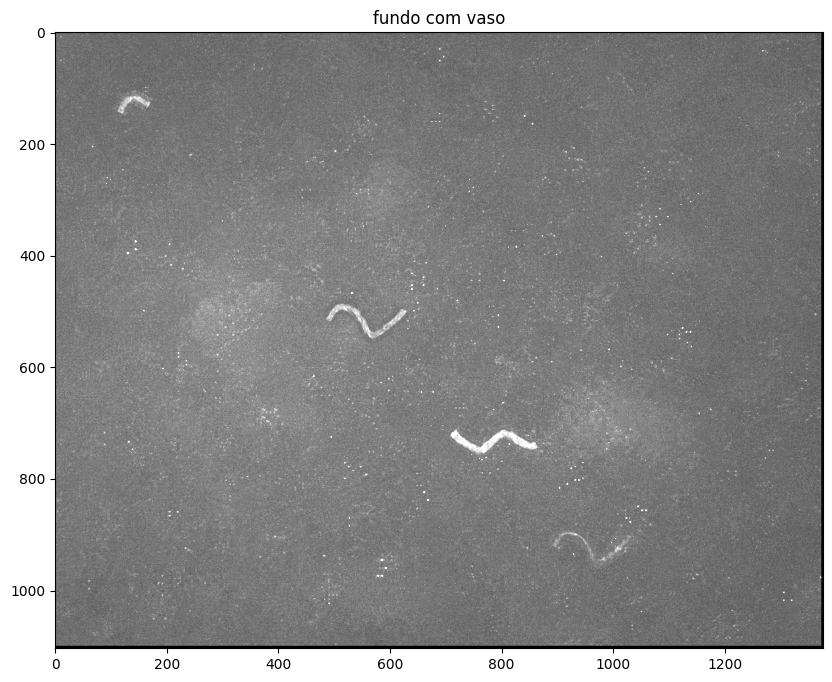

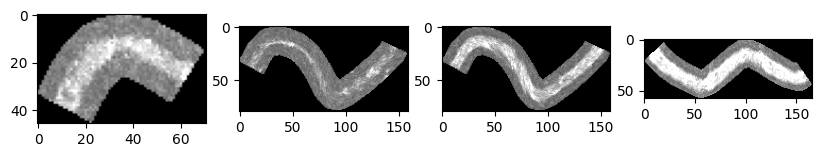

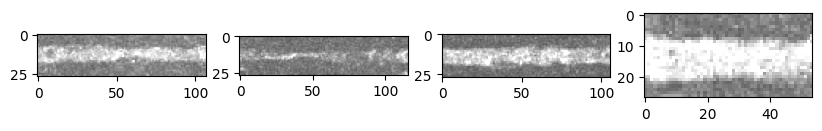

In [9]:

plt.figure(figsize=[10, 8])
plt.title("fundo com vaso")
plt.imshow(img, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("mapa_sem_artefatos")
for i in range(len(vetor_mapas_sem_artefatos)):  
    plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)  
    plt.imshow(vetor_mapas_sem_artefatos[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[10, 8])
plt.title("Mapas originais")
for i in range(len(vetor_mapas_originais)):  
    plt.subplot(1,len(vetor_mapas_originais),i+1)  
    plt.imshow(vetor_mapas_originais[i], 'gray', vmin=0, vmax=60)



In [10]:
array_pickles

['Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata10.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata2.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata7.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata4.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata6.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata3.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata5.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata8.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata1.pickle',
 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata0.pickle']